<a href="https://colab.research.google.com/github/ksvr1899/AI-Projects/blob/main/Build_an_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an AutoEncoder using PyTorch.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

# Exploring Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/AI_Projects/AutoEncoder/mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
image = data.iloc[7] # selecting image at index 7
image = np.array(image).astype('float32')
image = np.reshape(image,(28,28)) # reshaping image to 28 x 28
image = image / 255 # to scale image between 0 to 1

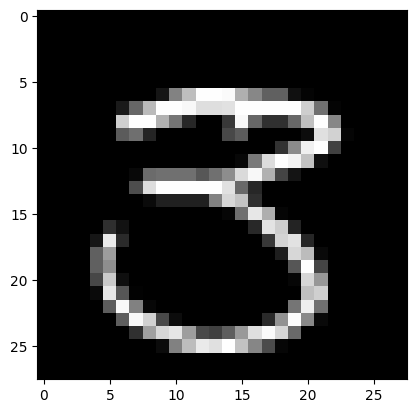

In [ ]:
plt.imshow(image,cmap = "gray")

In [ ]:
noisy_image = image + 0.2 * np.random.randn(*image.shape) # Adding random noise to image
noisy_image = np.clip(noisy_image,0,1) #ranging between 0 - 1

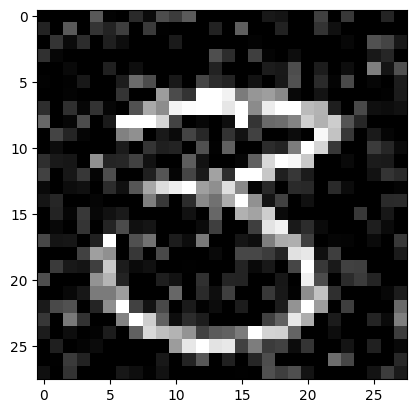

In [ ]:
plt.imshow(noisy_image,cmap = "gray")

# Data Preparation

In [ ]:
def show_image(noisy_image,org_image,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('denoised_image')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')


class ToTensorForAE(object):

    def __call__(self,sample):

        images,labels = sample

        images = images.transpose((2,0,1))
        labels = labels.transpose((2,0,1))

        return torch.from_numpy(images).float(),torch.from_numpy(labels).float()


In [ ]:
from torch.utils.data import Dataset

class MNIST_AE_Dataset(Dataset):

    def __init__(self,csv_file,noise_factor = 0.2,transform = None):

        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):

        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1)) / 255

        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img,0.,1.)

        sample = (noisy_img,img)

        if self.transform:
            sample = self.transform(sample)

        return sample

Here ToTensorForAE() is a function which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [ ]:
trainset = MNIST_AE_Dataset('/content/drive/MyDrive/AI_Projects/AutoEncoder/mnist_dataset.csv',transform = ToTensorForAE())

In [ ]:
print("Size of trainset : {}".format(len(trainset)))

Size of trainset : 42000


In [ ]:
noisy_image,org_image = trainset[6]
noisy_image.shape

torch.Size([1, 28, 28])

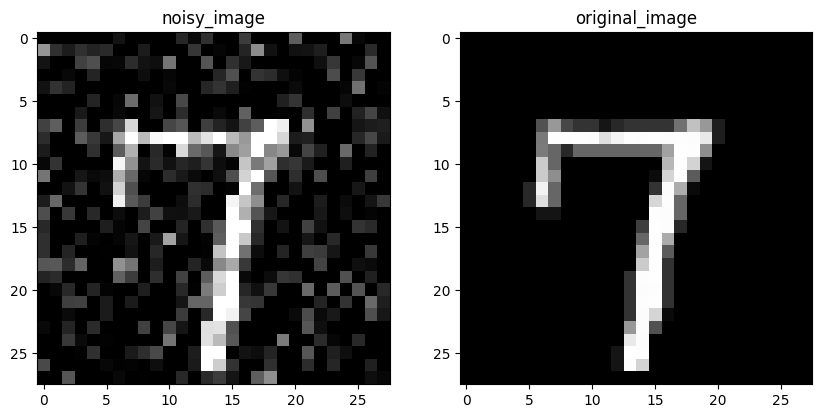

In [ ]:
show_image(noisy_image,org_image)

# Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)

In [ ]:
dataiter = iter(trainloader)
noisy_image, org_image = next(dataiter)

print("Shape of loading one batch : {}".format(noisy_image.shape))
print("Shape of loading one batch : {}".format(org_image.shape))

print("Total no. of batches present in trainloader : {}".format(len(trainloader))) #total no. of batches
print("Total no. of examples present in trainloader : {}".format(len(trainloader.dataset)))

Shape of loading one batch : torch.Size([16, 1, 28, 28])
Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total no. of batches present in trainloader : 2625
Total no. of examples present in trainloader : 42000


# Create AutoEncoder Model

In [ ]:
import torch
from torch import nn
from torchsummary import summary

In [ ]:
def Encoder():

    enc = nn.Sequential(

        nn.Conv2d(in_channels = 1, out_channels = 16,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )

    return enc

In [ ]:
def Decoder():

    dec = nn.Sequential(

        nn.ConvTranspose2d(in_channels = 32,out_channels = 16,kernel_size = (2,2),stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16,out_channels = 1,kernel_size = (2,2),stride = 2),
        nn.Sigmoid()
    )

    return dec

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()


        self.encoder = Encoder()
        self.decoder = Decoder()


    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder()
model

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [ ]:
summary(model,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model

In [ ]:
from torch import optim
from tqdm import tqdm

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
epochs = 5

In [ ]:
for i in range(epochs):

    train_loss = 0.0

    for noisy_image,image in tqdm(trainloader):

        optimizer.zero_grad()
        pred_image = model(noisy_image)
        loss = criterion(pred_image,image)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print("Epoch : {} Train Loss : {}".format(i+1,train_loss/len(trainloader)))

100%|██████████| 2625/2625 [00:48<00:00, 54.29it/s]


Epoch : 1 Train Loss : 0.016178039449488833


100%|██████████| 2625/2625 [00:46<00:00, 56.68it/s]


Epoch : 2 Train Loss : 0.005730802549847535


100%|██████████| 2625/2625 [00:45<00:00, 57.92it/s]


Epoch : 3 Train Loss : 0.005354960972354526


100%|██████████| 2625/2625 [00:45<00:00, 58.09it/s]


Epoch : 4 Train Loss : 0.0051252731202791136


100%|██████████| 2625/2625 [00:45<00:00, 57.51it/s]

Epoch : 5 Train Loss : 0.004947693854747783


# Plot Results

torch.Size([1, 28, 28])


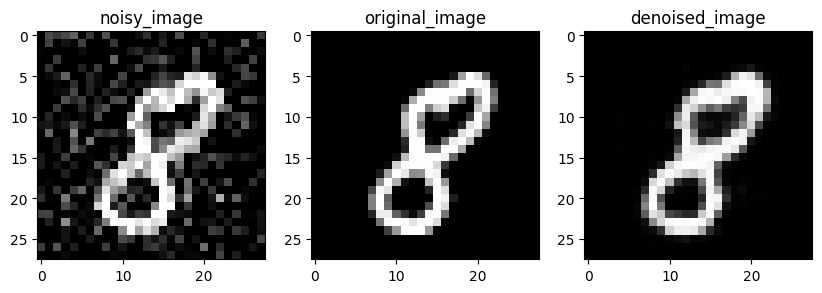

In [ ]:
model.eval()

with torch.no_grad():

    dataiter = iter(trainloader)
    sample = next(dataiter)

    noisy_image,image = sample

    index = 0

    pred_image = model(noisy_image[index].unsqueeze(0))
    print(pred_image.squeeze(0).shape)
    show_image(noisy_image[index],image[index],pred_image.squeeze(0))